In [13]:
import numpy as np
import tensorflow as tf

from tensorflow_models import nlp

In [14]:
# Build a small transformer network.
vocab_size = 100
network = nlp.networks.BertEncoder(
    vocab_size=vocab_size, 
    # The number of TransformerEncoderBlock layers
    num_layers=3)

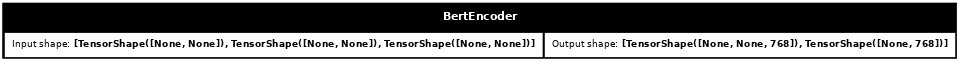

In [15]:
tf.keras.utils.plot_model(network, show_shapes=True, expand_nested=True, dpi=48)

In [16]:
# Create a BERT pretrainer with the created network.
num_token_predictions = 8
bert_pretrainer = nlp.models.BertPretrainer(
    network, num_classes=2, num_token_predictions=num_token_predictions, output='predictions')

Instructions for updating:
Classification as a network is deprecated. Please use the layers.ClassificationHead instead.


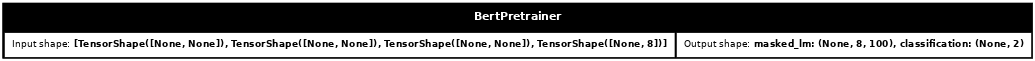

In [17]:
tf.keras.utils.plot_model(bert_pretrainer, show_shapes=True, expand_nested=True, dpi=48)

In [18]:
# We can feed some dummy data to get masked language model and sentence output.
sequence_length = 16
batch_size = 2

word_id_data = np.random.randint(vocab_size, size=(batch_size, sequence_length))
mask_data = np.random.randint(2, size=(batch_size, sequence_length))
type_id_data = np.random.randint(2, size=(batch_size, sequence_length))
masked_lm_positions_data = np.random.randint(2, size=(batch_size, num_token_predictions))

outputs = bert_pretrainer(
    [word_id_data, mask_data, type_id_data, masked_lm_positions_data])
lm_output = outputs["masked_lm"]
sentence_output = outputs["classification"]
print(f'lm_output: shape={lm_output.shape}, dtype={lm_output.dtype!r}')
print(f'sentence_output: shape={sentence_output.shape}, dtype={sentence_output.dtype!r}')

lm_output: shape=(2, 8, 100), dtype=tf.float32
sentence_output: shape=(2, 2), dtype=tf.float32


In [19]:
masked_lm_ids_data = np.random.randint(vocab_size, size=(batch_size, num_token_predictions))
masked_lm_weights_data = np.random.randint(2, size=(batch_size, num_token_predictions))
next_sentence_labels_data = np.random.randint(2, size=(batch_size))

mlm_loss = nlp.losses.weighted_sparse_categorical_crossentropy_loss(
    labels=masked_lm_ids_data,
    predictions=lm_output,
    weights=masked_lm_weights_data)
sentence_loss = nlp.losses.weighted_sparse_categorical_crossentropy_loss(
    labels=next_sentence_labels_data,
    predictions=sentence_output)
loss = mlm_loss + sentence_loss

print(loss)

tf.Tensor(5.2983174, shape=(), dtype=float32)


In [20]:
network = nlp.networks.BertEncoder(
        vocab_size=vocab_size, num_layers=2)

# Create a BERT trainer with the created network.
bert_span_labeler = nlp.models.BertSpanLabeler(network)

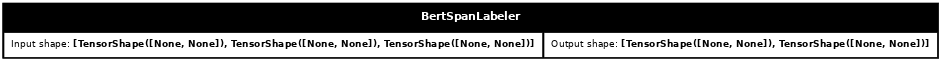

In [21]:
tf.keras.utils.plot_model(bert_span_labeler, show_shapes=True, expand_nested=True, dpi=48)

In [22]:
# Create a set of 2-dimensional data tensors to feed into the model.
word_id_data = np.random.randint(vocab_size, size=(batch_size, sequence_length))
mask_data = np.random.randint(2, size=(batch_size, sequence_length))
type_id_data = np.random.randint(2, size=(batch_size, sequence_length))

# Feed the data to the model.
start_logits, end_logits = bert_span_labeler([word_id_data, mask_data, type_id_data])

print(f'start_logits: shape={start_logits.shape}, dtype={start_logits.dtype!r}')
print(f'end_logits: shape={end_logits.shape}, dtype={end_logits.dtype!r}')

start_logits: shape=(2, 16), dtype=tf.float32
end_logits: shape=(2, 16), dtype=tf.float32


In [23]:
start_positions = np.random.randint(sequence_length, size=(batch_size))
end_positions = np.random.randint(sequence_length, size=(batch_size))

start_loss = tf.keras.losses.sparse_categorical_crossentropy(
    start_positions, start_logits, from_logits=True)
end_loss = tf.keras.losses.sparse_categorical_crossentropy(
    end_positions, end_logits, from_logits=True)

total_loss = (tf.reduce_mean(start_loss) + tf.reduce_mean(end_loss)) / 2
print(total_loss)

tf.Tensor(3.4136133, shape=(), dtype=float32)


In [24]:
network = nlp.networks.BertEncoder(
        vocab_size=vocab_size, num_layers=2)

# Create a BERT trainer with the created network.
num_classes = 2
bert_classifier = nlp.models.BertClassifier(
    network, num_classes=num_classes)

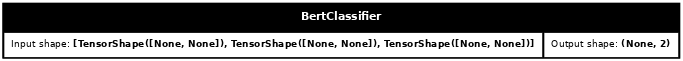

In [25]:
tf.keras.utils.plot_model(bert_classifier, show_shapes=True, expand_nested=True, dpi=48)

In [26]:
# Create a set of 2-dimensional data tensors to feed into the model.
word_id_data = np.random.randint(vocab_size, size=(batch_size, sequence_length))
mask_data = np.random.randint(2, size=(batch_size, sequence_length))
type_id_data = np.random.randint(2, size=(batch_size, sequence_length))

# Feed the data to the model.
logits = bert_classifier([word_id_data, mask_data, type_id_data])
print(f'logits: shape={logits.shape}, dtype={logits.dtype!r}')

logits: shape=(2, 2), dtype=tf.float32


In [27]:
labels = np.random.randint(num_classes, size=(batch_size))

loss = tf.keras.losses.sparse_categorical_crossentropy(
    labels, logits, from_logits=True)
print(loss)

tf.Tensor([0.6529862 0.3153265], shape=(2,), dtype=float32)
